# Optimizing thresholds in fraud protection

### Bayesian Optimization applied to rule based decision automation on 2 risk hyper-parameters

This notebook shows you how to learn aspects of your decision logic to make better decisions. We assume that we prescrip a transaction authorization based on knowledge and risk scores. These risks score are assumed to be computed by a machine learning model or any statistical model. Goal of this notebokk is to explain the intrest in applying optimization to tune the 


## Contents 
This notebook contains the following main sections:

1. [Install HyperOpt.](#configure)
2. [Define a fraud detection model.](#datamodel)
3. [Define a logic to protect transactions against frauds](#prescript)
4. [Define a measurement of a transaction authorization.](#viewdecisions)
5. [Define a aggregate measurement function.](#viewdecisions)
6. [Define a decision objective function.](#viewdecisions)
7. [Call the optimum search.](#viewdecisions)
8. [Visualize the optimum search results.](#viewdecisions)
9. [Summary and next steps.](#summary)  

To get the most out of this notebook, you should have some familiarity with the Python programming language.

Resources:
* https://towardsdatascience.com/an-introductory-example-of-bayesian-optimization-in-python-with-hyperopt-aae40fff4ff0
* Notebook: https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Introduction%20to%20Bayesian%20Optimization%20with%20Hyperopt.ipynb
* SEPA fraud scheme: https://www.ecb.europa.eu/pub/cardfraud/html/ecb.cardfraudreport201809.en.html#toc4

## 1 - Install hyperopt library and dependencies

In [2]:
%%capture
!pip install hyperopt
!pip install tqdm

Use a chosen version of tqdm for hyper opt

In [10]:
from faker import Faker

from pathlib import Path 

import json
import random 
import datetime

import os
import sys

import pandas as pd 
import numpy as np

import requests

import tqdm

import uuid

from pyspark.sql import SparkSession
from pyspark import SparkContext

from joblib import Parallel, delayed

print ("tqdm version : ", tqdm.__version__ )

tqdm version :  4.64.0


GLOBAL VARIBLES

In [7]:
SIMULATTE_BASE_DIR = "/Users/tiemokodembele/Documents/internShip/simulatte-public" #os.environ['SIMULATTE_BASE_DIR'] 
SIMULATTE_ONLINE_HOSTNAME = "localhost" #os.environ['SIMULATTE_ONLINE_HOSTNAME'] 
SIMULATTE_ANALYTIC_HOSTNAME = "localhost" #os.environ['SIMULATTE_ANALYTIC_HOSTNAME'] 

## 2 - Define a simple fraud data model

In [8]:
spark_session = SparkSession.builder.master("local[1]") \
                    .appName('SparkByExamples.com') \
                    .getOrCreate()

spark_context = SparkContext.getOrCreate()

############## DATA FROM REMOTE CSV FILE ################
def make_request(client, card, merchand, transaction, riskThresholds, request):
    client["id"] = str(uuid.uuid4())

    card["id"] = str(uuid.uuid4())
    card["risk"] = random.uniform(0, 1)
    card["client"] = client

    merchand["id"] = str(uuid.uuid4())
    merchand["risk"] = random.uniform(0, 1)

    transaction["id"] = str(uuid.uuid4())
    transaction["amount"] = random.randint(5000, 100000)
    transaction["card"] = card
    transaction["client"] = client
    transaction["merchand"] = merchand

    riskThresholds["card"] = random.uniform(0, 1)
    riskThresholds["merchand"] = random.uniform(0, 1)

    request["transaction"] = transaction
    request["riskThresholds"] = riskThresholds

    return json.dumps(request)

def get_data_from(data_sink_filepath, size, executor="JSE", file_format="PARQUET"):
    # check if data sink file already exists
    file = Path(data_sink_filepath)
    if file.exists():
        file = open(data_sink_filepath,"r+")
        file.truncate(0)
        file.close()

    # Models
    request = dict()
    card = dict()
    client = dict()
    merchand = dict()
    riskThresholds = dict()
    transaction = dict()

    requests = []

    if(executor=="JSE"):
        for counter in range(0, size):
            requests.append(make_request(client, card, merchand, transaction, riskThresholds, request))

        data = spark_context.textFile(data_sink_filepath)

    if(executor=="JSE_PARALLEL"):
        requests = Parallel(n_jobs=8)(
                        delayed(make_request)
                        (client, card, merchand, transaction, riskThresholds, request)
                        for row in tqdm(range(0,size))
                    )
    
    if(executor=="SPARK"):
        requests = spark_context.parallelize(range(0, size)) \
                .map(lambda counter : make_request(client, card, merchand, transaction, riskThresholds, request)) \
                .collect()

    if len(requests)!=0:
        with open(data_sink_filepath, 'a') as file:
            for request in requests:
                file.write(request)
                file.write('\n')

        if(file_format=="PARQUET"):
            data = spark_context.textFile(data_sink_filepath)
            data.saveAsTextFile(os.path.splitext(data_sink_filepath)[0])

            if Path(data_sink_filepath).exists():
                os.remove(data_sink_filepath)
        

size = 100
filesize = size
date_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
if(size>999 and size<=999_999): filesize = str(size)[:-3]+"K"
if(size>999_999): filesize = str(size)[:-6]+"M"
data_filepath = f"{SIMULATTE_BASE_DIR}/data/ADS/paramsOptimization/ads-22.0.1-paramsOptimization-requests-{date_time}-{filesize}.json"
get_data_from(data_filepath, size, "JSE", "JSON")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/31 14:09:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


DATA VIEW

In [11]:
######## GET DATA #########
dataSourcePathADS = data_filepath

inputData = []
with open(dataSourcePathADS) as file:
    while (line := file.readline().rstrip()):
        inputData.append(json.loads(line))

data = pd.json_normalize(inputData, max_level=1)
data.head(5)
#print("Data source uri : ",dataSourcePathADS)

,transaction.id,transaction.amount,transaction.card,transaction.client,transaction.merchand,riskThresholds.card,riskThresholds.merchand
0,b73a4588-aac4-4e10-b61d-1b64ff662405,95181,"{'id': '1986e586-1e50-440a-bd2d-5a836c018797',...",{'id': '9eada3e3-3077-4eef-96ec-9a3229486928'},"{'id': 'c6e7a436-54b9-4102-b835-d83da43deed3',...",0.373730,0.773355
1,e8467b2c-bc48-4511-a682-eae4308ddb74,6738,"{'id': '00013ea6-8848-4926-a224-c54ba55a1c74',...",{'id': 'a32bfdae-7a80-4434-8106-27aec0ea489d'},"{'id': '7934d4d0-780a-4d89-b119-60bc5e0c24e6',...",0.974750,0.852561
2,32c940b0-2b9b-422e-be31-95552fb0aa49,5168,"{'id': '50d8a741-9d02-4a47-8741-95fb30bbc86c',...",{'id': '26f19b31-ad1d-4865-9f41-91063c877b25'},"{'id': '3fe5a437-8452-45df-a498-6f6d8caf1a27',...",0.927199,0.688268
3,d6132c1a-9372-4787-9862-a35b2716f179,99444,"{'id': '6d43523e-62d3-45cd-ad1f-b38e708a7fde',...",{'id': 'd4a8d4cd-7524-4092-9724-303c3a731bc7'},"{'id': 'e9e5fcd9-d9e0-4834-93b1-af3488af2f3d',...",0.125215,0.795620
4,e6cf9ae3-fdda-4c53-99de-f5d639a99b84,45527,"{'id': 'b22144ff-7583-4e29-b5a6-83b7866e84bb',...",{'id': '94f6f69f-cf9b-49f5-a3fb-519d7314de14'},"{'id': '98e19257-7a73-49aa-a872-1fa5af402fc6',...",0.915700,0.577304


In [ ]:
#To execute when using parquet files
dataSourcePathADS = os.path.splitext(data_filepath)[0]

## 3 - Define a fraud detection service

In [39]:
datasinkFolderPath = f"{SIMULATTE_BASE_DIR}/data/ADS/fraudDetection"
createSimulationUrl = f"http://{SIMULATTE_ONLINE_HOSTNAME}:8080/v1/simulation/create"
deploymentSpaceId = "embedded"
decisionId = "_109077706%2Fsimulatte%2Ffraud_detection%2FdetectFraudDecisionService%2F1.5.0%2FdetectFraudDecisionService-1.5.0.jar"
operation_name = "Detect-fraud-in-card-transactions"
adsEndpoint1 = f"https://cpd-cp4a.apps.ads2201.cp.fyre.ibm.com/ads/runtime/api/v1/deploymentSpaces/{deploymentSpaceId}/decisions/{decisionId}/operations/{operation_name}/execute"
token = "MDgyMjEzNzA2OjB6M3lwc29MZTJOOE1sQ2pDVDVSVXlmSHNXRDhDbjBKc1ZKZlN1aEI="
BASIC_AUTH_USERNAME = "drsManager"
BASIC_AUTH_PASSWORD = "manager"

simulationObject = {
    "uid": 0,
    "name": "my simu",
    "description": "string",
    "createDate": "2022-05-18T23:31:19.828Z",
    "trace": True,
    "dataSource": {
      "format": "JSON",
      "uri": dataSourcePathADS,
      "username": "string",
      "password": "string"
    },
    "dataSink": {
      "format": "JSON",
      "folderPath": datasinkFolderPath,
      "username": "string",
      "password": "string"
    },
    "decisionService": {
      "type": "ADS",
      "endPoint": adsEndpoint1,
      "authType": "BASIC_AUTH",
      "username": BASIC_AUTH_USERNAME,
      "password": BASIC_AUTH_PASSWORD,
      "key": "string",
      "value": "string",
      "token": token,
      "headerPrefix": "string"
    },
    "metrics": [
      {
        "uid": 0,
        "name": "string",
        "type": "SPARK_SQL",
        "description": "string",
        "expression": "string"
      }
    ],
    "kpi": [
      {
        "uid": 0,
        "name": "string",
        "type": "SPARK_SQL",
        "description": "string",
        "result": {}
      }
    ]
  }



############## CREATE SIMULATION ################
try:    
    createSimulation = requests.post(createSimulationUrl, data = json.dumps(simulationObject), headers=headers)
    print("URL : ", createSimulationUrl)
    print("RESPONSE STATUS : ", createSimulation.status_code, "\n")
    if(createSimulation.status_code==200):
        print("RESPONSE CONTENT : ", json.dumps(createSimulation.json(), indent=5), "\n")
    else:
        print("Check server side. ERROR : ", createSimulation.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)

SyntaxError: invalid syntax (2695975167.py, line 26)

START SIMULATION

In [ ]:
simulationUid = createSimulation.json()["uid"]
startSimulationUrl = f"http://{SIMULATTE_ONLINE_HOSTNAME}:8080/v1/simulations/{simulationUid}/start/"
notebook_uri = f"{SIMULATTE_BASE_DIR}/notebooks/ADS/ads-vs-odm-loanvalidation-analytics.ipynb"
url_DSA1 = f"{SIMULATTE_BASE_DIR}/libs/ADS/fraud_detection_1.1.0.jar"
url_DSA2 = f"{SIMULATTE_BASE_DIR}/libs/ADS/fraud_detection_1.2.0.jar"
operation_name = "Detect-fraud-in-card-transactions"

run_config = {
    "name": "frauddetection",
    "description": "string",
    "createDate": "2022-05-18T23:31:19.828Z",
    "trace": False,
    "dataSink": {
      "format": "PARQUET",
      "folderPath": datasinkFolderPath,
      "username": "string",
      "password": "string"
    },
    "decisionService": {
      "type": "ADS",
      "endPoint": adsEndpoint1,
      "operationName": operation_name,
      "authType": "BASIC_AUTH",
      "username": BASIC_AUTH_USERNAME,
      "password": BASIC_AUTH_PASSWORD,
      "key": "string",
      "value": "string",
      "token": token,
      "headerPrefix": "string"
    },
    "executor": {
        "type": "SPARK_STANDALONE",
        "mode": "REMOTE",
        "capability": "ODM",
        "uid": 0
    },
    "notebookUri": notebook_uri
  }

############## START SIMULATION ################
try:    
    startSimulation = requests.post(startSimulationUrl, data = json.dumps(run_config), headers=headers)
    print("URL : ", startSimulationUrl)
    print("RESPONSE STATUS : ", startSimulation.status_code, "\n")
    if(startSimulation.status_code==200):
        print("YOUR SIMULATION IS STARTED !!! \n")
        print("RESPONSE CONTENT : ", json.dumps(startSimulation.json(), indent=5), "\n")
    else:
        if(startSimulation.status_code==500):
            print("Check server side. ERROR : ", startSimulation.json()["error"])
            print("Check server side. PATH : ", startSimulation.json()["error"])
        else:
            print("Check server side. ERROR : ", startSimulation.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)

## 4 - Define a fraud detection service metric function
This function measures the business performance of a fraud protection decision by the following cases:
<ul>
    <li>An authorized non fraudulent transaction rewards a fee.
    <li>An authorized but fraudulent transaction costs the amount of the transaction to be reimbursed to the client.
    <li>A blocked fraudulent transaction gets a zero result.
    <li>A blocked but non fraudulent transaction costs x% as an average of lost clients moving to other providers to make this transaction and possibly future ones.
</ul>

CREATE SIMULATION

In [40]:
datasinkFolderPath = f"{SIMULATTE_BASE_DIR}/data/ADS/fraudDetection"
createSimulationUrl = f"http://{SIMULATTE_ONLINE_HOSTNAME}:8080/v1/simulation/create"
deploymentSpaceId = "embedded"
decisionId = "_109077706%2Fsimulatte%2Ffraud_detection%2FdetectFraudDecisionService%2F1.5.0%2FdetectFraudDecisionService-1.5.0.jar"
operation_name = "Detect-fraud-in-card-transactions"
adsEndpoint1 = f"https://cpd-cp4a.apps.ads2201.cp.fyre.ibm.com/ads/runtime/api/v1/deploymentSpaces/{deploymentSpaceId}/decisions/{decisionId}/operations/{operation_name}/execute"
token = "MDgyMjEzNzA2OjB6M3lwc29MZTJOOE1sQ2pDVDVSVXlmSHNXRDhDbjBKc1ZKZlN1aEI="
BASIC_AUTH_USERNAME = "drsManager"
BASIC_AUTH_PASSWORD = "manager"

simulationObject = {
    "uid": 0,
    "name": "my simu",
    "description": "string",
    "createDate": "2022-05-18T23:31:19.828Z",
    "trace": True,
    "dataSource": {
      "format": "JSON",
      "uri": dataSourcePathADS,
      "username": "string",
      "password": "string"
    },
    "dataSink": {
      "format": "JSON",
      "folderPath": datasinkFolderPath,
      "username": "string",
      "password": "string"
    },
    "decisionService": {
      "type": "ADS",
      "endPoint": adsEndpoint1,
      "authType": "BASIC_AUTH",
      "username": BASIC_AUTH_USERNAME,
      "password": BASIC_AUTH_PASSWORD,
      "key": "string",
      "value": "string",
      "token": token,
      "headerPrefix": "string"
    },
    "metrics": [
      {
        "uid": 0,
        "name": "string",
        "type": "SPARK_SQL",
        "description": "string",
        "expression": "string"
      }
    ],
    "kpi": [
      {
        "uid": 0,
        "name": "string",
        "type": "SPARK_SQL",
        "description": "string",
        "result": {}
      }
    ]
  }



############## CREATE SIMULATION ################
try:    
    createSimulation = requests.post(createSimulationUrl, data = json.dumps(simulationObject), headers=headers)
    print("URL : ", createSimulationUrl)
    print("RESPONSE STATUS : ", createSimulation.status_code, "\n")
    if(createSimulation.status_code==200):
        print("RESPONSE CONTENT : ", json.dumps(createSimulation.json(), indent=5), "\n")
    else:
        print("Check server side. ERROR : ", createSimulation.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)

START SIMULATION

In [ ]:
simulationUid = createSimulation.json()["uid"]
startSimulationUrl = f"http://{SIMULATTE_ONLINE_HOSTNAME}:8080/v1/simulations/{simulationUid}/start/"
notebook_uri = f"{SIMULATTE_BASE_DIR}/notebooks/ADS/ads-vs-odm-loanvalidation-analytics.ipynb"
url_DSA1 = f"{SIMULATTE_BASE_DIR}/libs/ADS/fraud_detection_1.1.0.jar"
url_DSA2 = f"{SIMULATTE_BASE_DIR}/libs/ADS/fraud_detection_1.2.0.jar"
operation_name = "Detect-fraud-in-card-transactions"

run_config = {
    "name": "frauddetection",
    "description": "string",
    "createDate": "2022-05-18T23:31:19.828Z",
    "trace": False,
    "dataSink": {
      "format": "PARQUET",
      "folderPath": datasinkFolderPath,
      "username": "string",
      "password": "string"
    },
    "decisionService": {
      "type": "ADS",
      "endPoint": adsEndpoint1,
      "operationName": operation_name,
      "authType": "BASIC_AUTH",
      "username": BASIC_AUTH_USERNAME,
      "password": BASIC_AUTH_PASSWORD,
      "key": "string",
      "value": "string",
      "token": token,
      "headerPrefix": "string"
    },
    "executor": {
        "type": "SPARK_STANDALONE",
        "mode": "REMOTE",
        "capability": "ODM",
        "uid": 0
    },
    "notebookUri": notebook_uri
  }

############## START SIMULATION ################
try:    
    startSimulation = requests.post(startSimulationUrl, data = json.dumps(run_config), headers=headers)
    print("URL : ", startSimulationUrl)
    print("RESPONSE STATUS : ", startSimulation.status_code, "\n")
    if(startSimulation.status_code==200):
        print("YOUR SIMULATION IS STARTED !!! \n")
        print("RESPONSE CONTENT : ", json.dumps(startSimulation.json(), indent=5), "\n")
    else:
        if(startSimulation.status_code==500):
            print("Check server side. ERROR : ", startSimulation.json()["error"])
            print("Check server side. PATH : ", startSimulation.json()["error"])
        else:
            print("Check server side. ERROR : ", startSimulation.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)

## 5 - Read the decision dataset

This report post processes the result of a simulation that wrote a dataset of automataed decisions in a data lake or a local file system. The first decisions found in the simulation dataset look like below:

In [ ]:
datasinkPath = startSimulation.json()["dataSink"]["uri"] #f"{SIMULATTE_BASE_DIR}/data/ADS/loanvalidation/run_my runner_20220701_170948.json"

outputData = []
if os.path.exists(datasinkPath):
    with open(datasinkPath) as file:
        filesize = os.path.getsize(datasinkPath)
        if filesize == 0:
            print("The file {} is empty".format(datasinkPath))
        else:
            while (line := file.readline().rstrip()):
                jsonLine = dict()
                line_to_json = json.loads(line)
                jsonLine["request"] = line_to_json["request"]
                if(line_to_json["trace"]=="empty"): 
                    jsonLine["trace"] = "empty" 
                else: 
                    jsonLine["trace"] = line_to_json["trace"]
                jsonLine["response"] = line_to_json["response"]

                outputData.append(jsonLine)

datasink = pd.json_normalize(outputData)
datasink.head(5)

## 5 - Define a fraud detection service metric aggregate

This function aggregates the business results for a set of decisions.

In [41]:
# The Decision KPI function to measure the cost for a set of decisions
def computeDecisionAggregate(card_risk_threshold: float, merchand_risk_threshold: float):
    decision_total_loss = 0
    
    # Run a batch of decisions with and computes a cost metric for each
    # Decision
    client = Client(1233, 0.5)
    card = Card(1222, 0.95, client)
    merchand = Merchand(12222, 0.3)
    transaction = Transaction(1222, 1000, card, client, merchand)
    
    #Fraud label
    actual_fraud = True
    
    business_result = decisionServiceMetric(transaction, card_risk_threshold, merchand_risk_threshold, actual_fraud)
    
    aggregated_business_benefit = business_result
    
    # Decision
    client = Client(1233, 0.5)
    card = Card(1222, 0.8, client)
    merchand = Merchand(12222, 0.3)
    transaction = Transaction(1222, 1000, card, client, merchand)
    actual_fraud = True
    
    business_result = decisionServiceMetric(transaction, card_risk_threshold, merchand_risk_threshold, actual_fraud)
    
    aggregated_business_benefit += business_result
    
    # Decision
    client = Client(1233, 0.5)
    card = Card(1222, 0.5, client)
    merchand = Merchand(12222, 0.5)
    transaction = Transaction(1222, 1000, card, client, merchand)
    actual_fraud = True
    
    business_result = decisionServiceMetric(transaction, card_risk_threshold, merchand_risk_threshold, actual_fraud)
    
    aggregated_business_benefit += business_result
    
    # Decision
    client = Client(1233, 0.5)
    card = Card(1222, 0.3, client)
    merchand = Merchand(12222, 0.6)
    transaction = Transaction(1222, 1000, card, client, merchand)
    actual_fraud = False
    
    business_result = decisionServiceMetric(transaction, card_risk_threshold, merchand_risk_threshold, actual_fraud)
    
    aggregated_business_benefit += business_result
    
    # Decision
    client = Client(1233, 0.5)
    card = Card(1222, 0.2, client)
    merchand = Merchand(12222, 0.3)
    transaction = Transaction(1222, 100, card, client, merchand)
    actual_fraud = False
    
    business_result = decisionServiceMetric(transaction, card_risk_threshold, merchand_risk_threshold, actual_fraud)
    
    aggregated_business_benefit += business_result
    
    # Return the value of the polynomial
    # Chane sign to transform the business result into a loss to be minimized
    return - aggregated_business_benefit

## 6 - Define a decision objective
Call the aggregate of business results with the hyper-parameter values.

In [42]:
def decisionObjective(threshold_space):
    """Objective function to minimize"""

    # Return the value of the decision aggregation
    return computeDecisionAggregate(threshold_space['x1'], threshold_space['x2'])

## 7 - Define an optimum search
By using hyperopt library we define an optimum search over x trials. Optimization search algoritm takes the decision objective function and explores the hyper-parameter space in a limited number of trials to find the lower value.

In [43]:
from hyperopt import hp, tpe, fmin, Trials

import numpy as np
import pandas as pd

def searchOptimum ( space, function ):

    # Create the algorithm
    tpe_algo = tpe.suggest
    
    # Create a trials object
    tpe_trials = Trials()

    # Run 2000 evals with the tpe algorithm
    tpe_best = fmin(fn=function, space=space, 
                algo=tpe_algo, trials=tpe_trials, 
                max_evals=5000)

    print(tpe_best)
    
    #print(tpe_trials.idxs_vals[0])
    
    #print(tpe_trials.idxs_vals[0]['x1'])
    
    tpe_results = pd.DataFrame({
        'loss': [x['loss'] for x in tpe_trials.results], 
        'iteration': tpe_trials.idxs_vals[0]['x1'],
        'x1': tpe_trials.idxs_vals[1]['x1'],
        'x2': tpe_trials.idxs_vals[1]['x2']})
    
    tpe_results['rolling_average_x1'] = tpe_results['x1'].rolling(50).mean().fillna(method = 'bfill')
    tpe_results['rolling_average_x2'] = tpe_results['x2'].rolling(50).mean().fillna(method = 'bfill')
    tpe_results['rolling_average_loss'] = tpe_results['loss'].rolling(50).mean().fillna(method = 'bfill')
    
    tpe_results['card_risk'] = tpe_results['x1']
    tpe_results['merchand_risk'] = tpe_results['x2']
    tpe_results['business_result'] = - tpe_results['loss']
    
    return (tpe_best, tpe_results)
    

## 8 - Run the optimum search

We run the optimum search against the fraud decision objective function with a bi-dimensional hyper-parameter space. Search runs 2000 trials of the decision set to navigate to the lowest loss value.

In [44]:
# Create the domain space
#space = hp.uniform('x1', 0, 1)

space = {
    'x1': hp.uniform('x1', 0, 1),
    'x2': hp.uniform('x2', 0, 1)
}

(tpe_best, tpe_results) = searchOptimum(space, decisionObjective)

tpe_results.head(5)

100%|██████████| 5000/5000 [02:03<00:00, 40.43trial/s, best loss: -90.0]
{'x1': 0.6840806497861077, 'x2': 0.3119474894607792}


,loss,iteration,x1,x2,rolling_average_x1,rolling_average_x2,rolling_average_loss,card_risk,merchand_risk,business_result
0,3000.0,0,0.883150,0.527777,0.55481,0.490747,1183.0,0.883150,0.527777,-3000.0
1,3000.0,1,0.964885,0.748296,0.55481,0.490747,1183.0,0.964885,0.748296,-3000.0
2,-90.0,2,0.684081,0.311947,0.55481,0.490747,1183.0,0.684081,0.311947,90.0
3,940.0,3,0.419594,0.653119,0.55481,0.490747,1183.0,0.419594,0.653119,-940.0
4,10.0,4,0.086125,0.717060,0.55481,0.490747,1183.0,0.086125,0.717060,-10.0


## 9 - Visualize the results

In [13]:
!pip install brunel
import brunel

     |████████████████████████████████| 2.2 MB 25.2 MB/s eta 0:00:01
  Using cached jupyter_pip-0.3.1-py3-none-any.whl
     |████████████████████████████████| 199 kB 48.6 MB/s eta 0:00:01
  Created wheel for brunel: filename=brunel-2.6.2-py3-none-any.whl size=2161232 sha256=64b4cf55453e987a4572163ca99d783570c6f777b922075885bb18b1fb373c7e
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/54/30/93/09b9dadd25d63eaebae5f89662ec401689e6ceddfe90b47f65
Successfully built brunel


In [36]:
print(tpe_results)

        loss  iteration        x1        x2  rolling_average_x1  \
0     3000.0          0  0.515853  0.821120            0.375412   
1       10.0          1  0.435498  0.108831            0.375412   
2     1970.0          2  0.732930  0.392465            0.375412   
3     3000.0          3  0.991902  0.811620            0.375412   
4      -90.0          4  0.303641  0.657273            0.375412   
...      ...        ...       ...       ...                 ...   
4995   -90.0       4995  0.358645  0.603546            0.336662   
4996   -90.0       4996  0.339645  0.604018            0.339637   
4997   -90.0       4997  0.358839  0.598304            0.342827   
4998   -90.0       4998  0.356906  0.594146            0.344805   
4999   -90.0       4999  0.360985  0.586637            0.347146   

      rolling_average_x2  rolling_average_loss  card_risk  merchand_risk  \
0               0.603202                 851.0   0.515853       0.821120   
1               0.603202                 85

<AxesSubplot:xlabel='x1', ylabel='x2'>

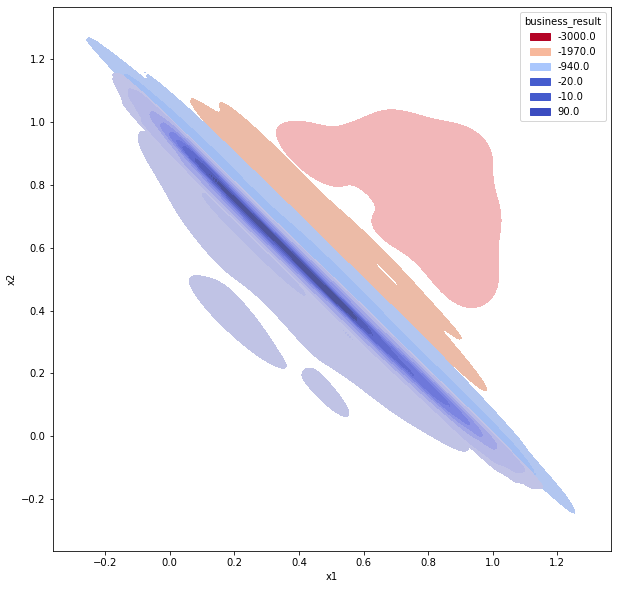

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

#palette = sns.color_palette("crest")
#palette.reverse()

plt.figure(figsize=(10,10))
sns.kdeplot(
    data=tpe_results, x="x1", y="x2", hue="business_result", palette="coolwarm_r", fill=True,
)

In [23]:
%brunel data('tpe_results') x(card_risk) y(merchand_risk) color(loss:green-red) 

<IPython.core.display.Javascript object>

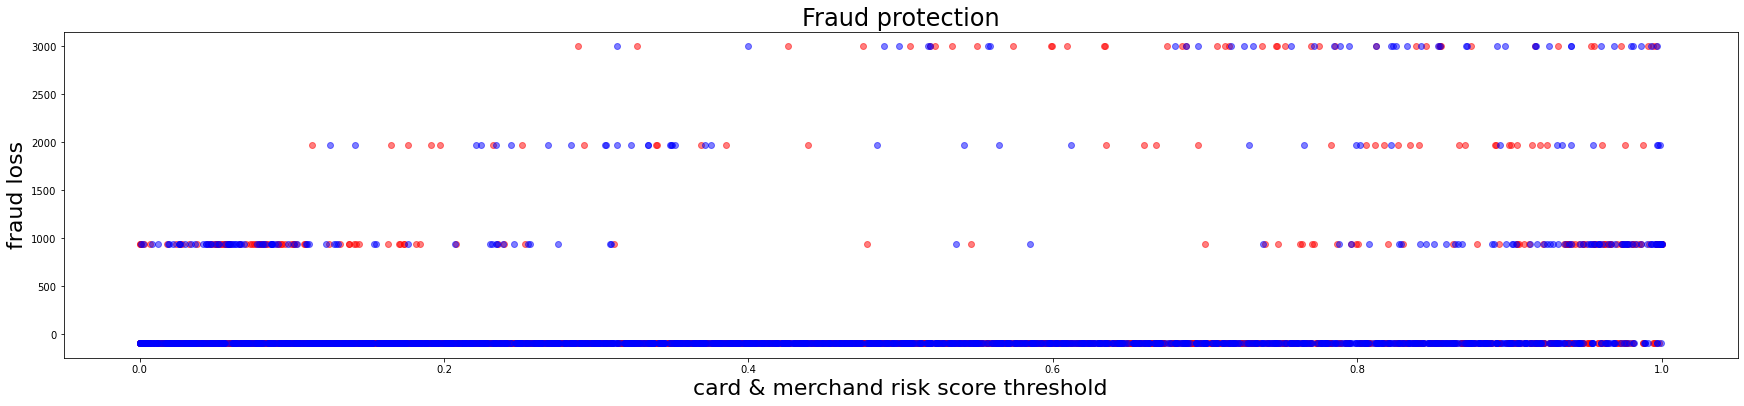

In [17]:
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize = (30, 6))
plt.plot(tpe_results['x1'], tpe_results['loss'],  'ro', alpha = 0.5);
plt.plot(tpe_results['x2'], tpe_results['loss'],  'bo', alpha = 0.5);

plt.xlabel('card & merchand risk score threshold', size = 22); 
plt.ylabel('fraud loss', size = 22); 
plt.title('Fraud protection', size = 24);

TypeError: '<' not supported between instances of 'dict' and 'float'

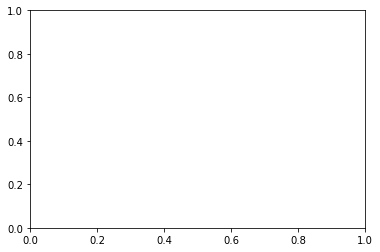

In [29]:

import seaborn as sns
from hyperopt.pyll.stochastic import sample

def displayDomainSpace ( space ):
    samples = []

    for _ in range(2000):
        samples.append(sample(space))
    
    plt.hist(samples, bins = 40, edgecolor = 'black'); 
    plt.xlabel('x1'); plt.ylabel('Frequency'); plt.title('Domain Space');
   

def displayTpeValues ( tpe_results ):
    plt.figure(figsize = (10, 8))
    plt.plot(tpe_results['iteration'], tpe_results['x1'],  'bo', alpha = 0.5);
    plt.xlabel('Iteration', size = 22); plt.ylabel('x1 value', size = 22); plt.title('TPE Sequence of Values', size = 24);

    plt.figure(figsize = (10, 8))
    plt.plot(tpe_results['iteration'], tpe_results['loss'], 'bo', alpha = 0.3);
    plt.xlabel('iteration'); plt.ylabel('loss'); plt.title('TPE Sequence of Losses');
    
def displayTpeHistogram ( tpe_results ): 
    plt.figure(figsize = (8, 6))
    plt.hist(tpe_results['x1'], bins = 50, edgecolor = 'k');
    plt.title('Histogram of TPE Values'); plt.xlabel('Value of x1'); plt.ylabel('Count');
    
displayDomainSpace ( space)
displayTpeHistogram ( tpe_results )
displayTpeValues ( tpe_results )